In [1]:
#imports
import json
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict
import networkx as nx
import re
import matplotlib.pyplot as plt

In [2]:
#Read a JSON file
def read_input(file):
    content = None
    with open(file, "r") as arq:
        content = json.load(arq)
    return content

def import_floyd_warshall(filename):
    graph = nx.Graph()
    with open(filename) as file:
        data = json.load(file)
    graph.add_edges_from([(int(re.findall("(?<!\d)\d+(?!\d)",x)[0]), int(re.findall("(?<!\d)\d+(?!\d)",x)[1]), data["EDGES"][x]) for x in data["EDGES"].keys() if (re.findall("(?<!\d)\d+(?!\d)",x)[0] <= re.findall("(?<!\d)\d+(?!\d)",x)[1])])
    return nx.floyd_warshall_predecessor_and_distance(graph, weight="DISTANCE")[1]


def func_edges_sigma(edges_S, edges_sigma):
    to_return = list()
    for s in edges_S:
        to_return.append(edges_sigma[s])

In [3]:
depots = None
edges = None
model = None
edges_sigma = None

In [4]:
#callback
def edges_to_graph(regex_edges):
    graph = defaultdict(list)
    for e in regex_edges.keys():
        if regex_edges[e] > 0.9:
            graph[e[0]].append(e[1])
            graph[e[1]].append(e[0])
    return graph

def breadth_first_search(graph, depot):
    visited = dict()
    for i in graph.keys():
        visited[i] = False

    queue = []

    queue.append(depot)
    visited[depot] = True

    while queue:
        node = queue.pop(0)
        for i in graph[node]:
            if visited[i] == False:
                queue.append(i)
                visited[i] = True
    
    to_return = list()
    for i in visited:
        if i == False:
            for e in graph[i]:
                if (e,i) in edges and (e,i) not in to_return:
                    to_return.append((e,i))
                elif (i,e) in edges and (i,e) not in to_return:
                    to_return.append((i,e))
        
    
    return to_return

def variable_regex(depot):
    name = list()
    for var in model.getVars():
        if "DepotEdgeAssign["+str(depot)+",(" in var.varName:
            name.append(var)
    
    value = model.cbGetSolution(name)
    to_return = dict()

    for i in range(len(edges)):
        to_return[edges[i]] = value[i]

    return to_return

def variable_regex_final(depot):
    name = list()
    for var in model.getVars():
        if "DepotEdgeAssign["+str(depot)+",(" in var.varName:
            name.append(var)
    
    value = model.getAttr("X",name)
    to_return = dict()

    for i in range(len(edges)):
        to_return[edges[i]] = value[i]

    return to_return
    

def mycallback(model, where):
    if where == GRB.Callback.MIPSOL:
        for p in depots:
            unreached_edges = breadth_first_search(edges_to_graph(variable_regex(p)), p)
            if len(unreached_edges) > 0:
                cuts = model.addConstrs((gp.quicksum(x[p,s] for s in edges_sigma[e]) - x[p,e] >= 0 for e in unreached_edges))

In [5]:
import os
from os import walk

path = "Test/"

print(next(walk(path), (None, None, []))[2])




['Lpr-a-01.json', 'Lpr-a-02.json']


inputfile
Lpr-a-01.json
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-3610QM CPU @ 2.30GHz, instruction set [SSE2|AVX]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 448 rows, 740 columns and 2352 nonzeros
Model fingerprint: 0x143618ea
Variable types: 300 continuous, 440 integer (440 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+04]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+03]
Found heuristic solution: objective 2544.0000000
Presolve removed 208 rows and 404 columns
Presolve time: 0.01s
Presolved: 240 rows, 336 columns, 1368 nonzeros
Variable types: 0 continuous, 336 integer (336 binary)
Found heuristic solution: objective 2256.0000000

Root relaxation: objective 1.582784e+03, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

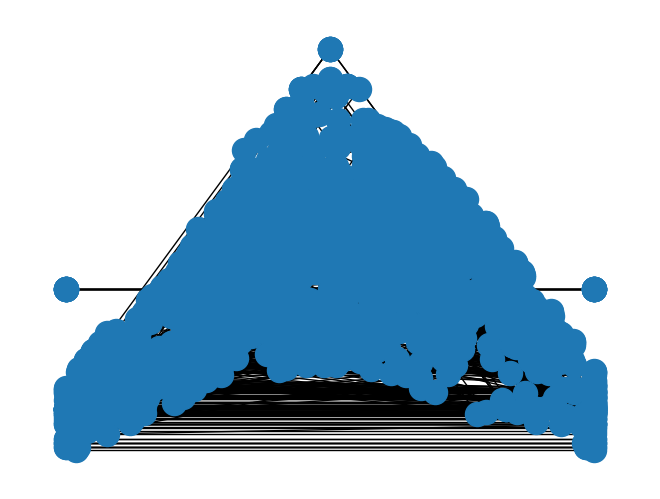

In [7]:
#data

#read the JSON file

files = next(walk(path), (None, None, []))[2]

for input_file in files:

    file_path = path+input_file
    print("inputfile")
    print(input_file)

    input_content = read_input(file_path)

    #TOLERANCE (values suggested by Garcia-Ayala's paper)
    tolerance = (0.1, 0.05)

    #DEPOTS
    #list of depots
    #format: [1, 2, 3]
    depots = list()
    for p in input_content['DEPOTS']:
        depots.append(int(p))

    #VERTICES
    #list of vertices
    #format: [1, 2, 3, 4]
    vertices = list()
    # for i in input_content['NODES'].keys():
    #     vertices.append(int(i))

    dictionary = dict()

    # for a in input_content['NODES'].keys():
    #     for b in input_content['NODES'][a].keys():
    #         if (int(b),int(a)) not in dictionary.keys():
    #             dictionary[int(a),int(b)] = int(input_content['NODES'][a][b]['DISTANCE']),int(input_content['NODES'][a][b]['DEMAND'])

    for e in input_content['EDGES'].keys():
        e_aux = e.split(',')
        a = int(e_aux[0].split('(')[1])
        b = int(e_aux[1].split(')')[0])
        if (b,a) not in dictionary.keys():
            dictionary[a,b] = int(input_content['EDGES'][e]['DISTANCE']),int(input_content['EDGES'][e]['DEMAND'])
        if a not in vertices:
            vertices.append(a)

    #EDGES
    #format: (2, 14)
    #        (2, 3)
    #DISTANCE
    #format: {(2, 14): 34, (2, 3): 19}
    #DEMAND
    #format: {(2, 14): 240, (2, 3): 137}
    edges, distance, demand = gp.multidict(dictionary)

    #AVERAGE DEMAND
    avg_demand = 0
    for d in demand.keys():
        avg_demand += demand[d]

    avg_demand /= len(depots)

    #EDGES DELTA
    #dictionary of all the edges that have 'i' as one of its ends
    #format: {2: [(2, 14), (2, 3), (2, 8)], 14: [(2, 14), (14, 7)]}
    edges_delta = dict()

    for i in vertices:
        edges_delta[i] = list()
        for e in edges:
            if e[0] == i or e[1] == i:
                edges_delta[i].append(e)

    #DEPOT VERTEX
    #tuples that relate a depot to a vertex
    #format: [(1, 2), (1, 14)]
    depot_vertex = list()

    for p in depots:
        for i in vertices:
            depot_vertex.append((p, i))

    matrix2 = import_floyd_warshall(file_path)

    dictionary = dict()
    for p in depots:
        for e in edges:
            dictionary[p,e] = min(matrix2[p][e[0]],matrix2[p][e[1]])


    #DEPOT EDGE
    #tuples that relate a depot to an edge
    #format: ( 1 , (2, 14)  )
    #        ( 1 , (2, 3)   )
    #DEPOT DISTANCE
    #dictionary with the distance between a depot and an edge
    #format: {(1, (2, 14)): 60, (1, (2, 3)): 41}
    depot_edge, depot_dist = gp.multidict(dictionary)

    dictionary = dict()

    #PARITY LOOSE
    # list of vertices to assign if a vertex loose its parity or not
    parity_loose = list()

    #list of even parity vertices
    vertices_even = list()
    #list of odd parity vertices
    vertices_odd = list()

    for i in range(len(vertices)+1):
        dictionary[i] = 0
        if i != 0:
            parity_loose.append(i)

    for e in edges:
        dictionary[e[0]] += 1
        dictionary[e[1]] += 1

    for i in range(len(vertices)+1):
        if i != 0 and dictionary[i]%2 == 0:
            vertices_even.append(i)
        elif i != 0 and dictionary[i]%2 == 1:
            vertices_odd.append(i)

    dictionary = dict()

    for i in vertices:
        for p in depots:
            dictionary[i,p] = 0

    #PARITY
    #dictionary that relates a vertex and a depot, and indicates its parity
    parity = dictionary
    #the same as the above but binary
    parity_0 = dictionary

    edges_sigma = dict()
    edges_S = dict()
    for e in edges:
        edges_sigma[e] = list()
        edges_S[e] = list()
        for f in edges:
            if (e[0] == f[0] or e[0] == f[1] or e[1] == f[0] or e[1] == f[1]) and (e != f):
                edges_sigma[e].append(f)
            elif (e != f):
                edges_S[e].append(f)

    edges_sigma_S = dict()
    for e in edges:
        edges_sigma_S[e] = list()
        for i in edges_S[e]:
            for j in edges_sigma[i]:
                edges_sigma_S[e].append(j)

    #declare model
    model = gp.Model('RAP')

    #decision variables
    b = model.addVars(depot_dist, name="DepotEdgeDistance")
    x = model.addVars(depot_edge, vtype=gp.GRB.BINARY, name="DepotEdgeAssign")
    w = model.addVars(depot_vertex, vtype=gp.GRB.BINARY, name="DepotVertexIncident")
    z = model.addVars(parity, lb = 0, name = "Parity")
    z_0 = model.addVars(parity_0, vtype=gp.GRB.BINARY, name = "OddParity")
    r = model.addVars(parity_loose, vtype=gp.GRB.BINARY)

    #constrains
    constrain_2 = model.addConstrs((gp.quicksum(x[p,e] for p in depots) == 1 for e in edges), name='constrain2')
    #constrain_3 = model.addConstrs((gp.quicksum(x[p,s] for s in edges_sigma_S[e]) - gp.quicksum(x[p,s] for s in edges_S[e]) >= x[p,e] - len(edges_S[e]) for p in depots for e in edges for S in edges), name='constrain 3')
    constrain_4 = model.addConstrs((gp.quicksum(x[p,e]*demand[e] for e in edges) <= avg_demand*(1 + tolerance[0]) for p in depots), name='constrain4')
    constrain_5 = model.addConstrs((gp.quicksum(x[p,e]*demand[e] for e in edges) >= avg_demand*(1 - tolerance[0]) for p in depots), name='constrain5')
    constrain_6 = model.addConstrs((gp.quicksum(x[p,e] for e in edges_delta[i]) <= 9999*w[p,i] for p in depots for i in vertices), name='constrain6')
    constrain_7 = model.addConstrs((gp.quicksum(x[p,e] for e in edges_delta[i]) >= w[p,i] for p in depots for i in vertices), name='constrain7')
    constrain_8 = model.addConstrs((gp.quicksum(x[p,e] for e in edges_delta[i]) == 2*z[i,p]+z_0[i,p] for p in depots for i in vertices), name='constrain8')
    constrain_9 = model.addConstrs((gp.quicksum(z_0[i,p] for p in depots) >= r[i] for i in vertices_even), name='constrain9')
    constrain_10 = model.addConstrs((gp.quicksum(z_0[i,p] for p in depots) <= r[i]*len(depots) for i in vertices_even), name='constrain10')
    constrain_11 = model.addConstrs((gp.quicksum(z_0[i,p] for p in depots) - 1 >= r[i] for i in vertices_odd), name='constrain11')
    constrain_12 = model.addConstrs((gp.quicksum(z_0[i,p] for p in depots) - 1 <= r[i]*len(depots) for i in vertices_odd), name='constrain12')
    constrain_13 = model.addConstr((gp.quicksum(r[i] for i in vertices)/len(vertices) <= tolerance[1]), name='constrain13')

    #objective
    model.setObjective(x.prod(depot_dist), GRB.MINIMIZE)

    #run
    model.optimize(mycallback)

    model.write(f"{path}output/{input_file}")





    for p in depots:
        edges_p = variable_regex_final(p)
        G = nx.Graph()
        for e in edges_p.keys():
            if edges_p[e] > 0.9:
                G.add_edge(e[0], e[1])
                nx.draw_planar(G)
                aux = input_file.split('.')[0]
                plt.savefig(f'{path}IMG/{aux}-{p}.PNG')
        